### FFN and RNN on semeval. 

In [2]:

# %%
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast  # For safely evaluating strings containing Python literals
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

vocab_size = 1502  # Size of the vocabulary
# vocab_size = min(vocab_size, 2000)  # Reduce vocab size to 15,000


def index_to_one_hot(index, vocab_size):
    """ Convert an index to a one-hot encoded vector """
    one_hot = torch.zeros(vocab_size)
    one_hot[index] = 1
    return one_hot

class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): Dataframe containing 'padded_review' and 'label'.
        """
        self.reviews = dataframe['padded_review']
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        indices = self.reviews.iloc[idx]
        # Ensure indices are within the vocab_size range by clamping
        indices = [min(index, vocab_size - 1) for index in indices]
        one_hot_encoded = torch.stack([index_to_one_hot(index, vocab_size) for index in indices])
        return one_hot_encoded, self.labels.iloc[idx]


train_df = pd.read_csv('train_data_final_2.csv')
train_df = train_df.sample(n=2000, random_state=42)  # Sampling 1000 examples due to dataset size

test_df = pd.read_csv('test_data_final_2.csv')
test_df = test_df.sample(n=1000, random_state=42)  # Sampling 1000 examples due to dataset size

dev_df = pd.read_csv('dev_data_final_2.csv')
dev_df = dev_df.sample(n=300, random_state=42)  # Sampling 1000 examples due to dataset size

# Splitting data into train, dev, and test sets
# train_data, test_data = train_test_split(test_df, test_size=0.2, random_state=42)
# train_data, dev_data = train_test_split(train_df, test_size=0.1, random_state=42)


test_data = test_df

# Truncate the sequences to max_length within the DataFrame
max_length = 11 # Truncate sequences to 100 tokens

# Apply truncation directly to the 'padded_review' column in each DataFrame
train_df['padded_review'] = train_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])
dev_df['padded_review'] = dev_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])

test_df['padded_review'] = test_df['padded_review'].apply(lambda review: ast.literal_eval(review)[:max_length])


# Ensure labels are numeric (convert if necessary)
train_df['label'] = pd.to_numeric(train_df['label'])
dev_df['label'] = pd.to_numeric(dev_df['label'])
test_df['label'] = pd.to_numeric(test_df['label'])

# Create datasets
train_dataset = SentimentDataset(train_df)
dev_dataset = SentimentDataset(dev_df)
test_dataset = SentimentDataset(test_df)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print data loader counts
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in dev loader: {len(dev_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")



Number of batches in training loader: 125
Number of batches in dev loader: 19
Number of batches in test loader: 63


In [3]:
# Print a dataloader batch
for X_batch, y_batch in train_loader:
    print("Batch X shape:", X_batch.shape)  # Shape of the batch
    print("Batch Y shape:", y_batch.shape)  # Shape of the labels
    # print("Batch X content:\n", X_batch)    # Content of one-hot encoded vectors
    print("Batch Y content:", y_batch)      # Content of labels
    break  # Break after printing the first batch to avoid printing multiple batches

Batch X shape: torch.Size([16, 11, 1502])
Batch Y shape: torch.Size([16])
Batch Y content: tensor([1, 1, 1, 1, 2, 0, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1])


#### isse aage krna h 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


class FFN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, dropout_prob=0.5):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout after first hidden layer
        
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout after second hidden layer
        
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input for the linear layers
        
        # First layer with ReLU and Dropout
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        
        # Second layer with ReLU and Dropout
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        
        # Output layer (logits)
        logits = self.fc3(x)
        return logits  # CrossEntropyLoss handles the softmax


# Hyperparameters
input_size = 11 * 1502  # Adjust based on input shape
hidden1_size = 256
hidden2_size = 128
output_size = 3  # 3 classes for sentiment (-ve, neutral, +ve)
learning_rate = 0.001
num_epochs = 50  
patience = 5
early_stopping_enabled = True

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FFN(input_size, hidden1_size, hidden2_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss includes softmax internally
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
# Calculate and print the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


FFN(
  (fc1): Linear(in_features=16522, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)
Total number of parameters: 4263171


In [5]:
# Track losses and accuracies
train_losses = []
dev_losses = []
dev_accuracies = []

best_dev_accuracy = 0.0
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0  # Counter for early stopping

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()

        # Forward pass
        logits = model(batch_X)
        
        # Compute the loss (CrossEntropyLoss includes softmax)
        loss = criterion(logits, batch_Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluation on the development set
    model.eval()
    dev_preds = []
    dev_labels = []
    dev_running_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).long()

            logits = model(batch_X)
            loss = criterion(logits, batch_Y)
            dev_running_loss += loss.item() * batch_X.size(0)

            # Apply softmax to logits to get class probabilities and then take the argmax
            probabilities = model.softmax(logits)
            preds = torch.argmax(probabilities, dim=1)  # Get class predictions
            dev_preds.extend(preds.cpu().numpy())
            dev_labels.extend(batch_Y.cpu().numpy())

    dev_loss = dev_running_loss / len(dev_loader.dataset)
    dev_losses.append(dev_loss)
    dev_accuracy = accuracy_score(dev_labels, dev_preds)
    dev_accuracies.append(dev_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")

    # Early stopping and saving the best model based on dev accuracy
    if dev_accuracy > best_dev_accuracy:
        best_dev_accuracy = dev_accuracy
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1  # Increment the early stopping counter

    if early_stopping_enabled and epochs_no_improve == patience:
        print(f"Early stopping triggered after {epoch+1} epochs with no improvement.")
        break



Epoch [1/50], Train Loss: 1.0333, Dev Loss: 1.0514, Dev Accuracy: 0.4733
Epoch [2/50], Train Loss: 0.9112, Dev Loss: 1.0018, Dev Accuracy: 0.5167
Epoch [3/50], Train Loss: 0.4934, Dev Loss: 1.1800, Dev Accuracy: 0.5333
Epoch [4/50], Train Loss: 0.1828, Dev Loss: 1.4512, Dev Accuracy: 0.5267
Epoch [5/50], Train Loss: 0.0788, Dev Loss: 1.6282, Dev Accuracy: 0.5267
Epoch [6/50], Train Loss: 0.0513, Dev Loss: 1.8157, Dev Accuracy: 0.5033
Epoch [7/50], Train Loss: 0.0305, Dev Loss: 1.8857, Dev Accuracy: 0.5167
Epoch [8/50], Train Loss: 0.0219, Dev Loss: 2.1366, Dev Accuracy: 0.5067
Early stopping triggered after 8 epochs with no improvement.


In [6]:
# Load the best model
model.load_state_dict(best_model_state)
model.eval()

# Testing on the test set
test_preds = []
test_labels = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()
        logits = model(batch_X)

        # Apply softmax to get probabilities and argmax to get class predictions
        probabilities = model.softmax(logits)
        preds = torch.argmax(probabilities, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_Y.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Detailed metrics for each class
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    test_labels, test_preds, labels=[0, 1, 2]
)

# Print classification report. 
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

print("\nPer Class Metrics:")
for i in range(3):
    print(f"Class {i} - Precision: {precision_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, F1-Score: {f1_per_class[i]:.4f}")



Test Accuracy: 0.5530
Test Precision: 0.5111
Test Recall: 0.4701
Test F1-Score: 0.4665

Classification Report:
              precision    recall  f1-score   support

    Negative       0.33      0.20      0.25       145
     Neutral       0.54      0.80      0.65       444
    Positive       0.66      0.41      0.50       411

    accuracy                           0.55      1000
   macro avg       0.51      0.47      0.47      1000
weighted avg       0.56      0.55      0.53      1000


Per Class Metrics:
Class 0 - Precision: 0.3295, Recall: 0.2000, F1-Score: 0.2489
Class 1 - Precision: 0.5409, Recall: 0.8041, F1-Score: 0.6467
Class 2 - Precision: 0.6627, Recall: 0.4063, F1-Score: 0.5038


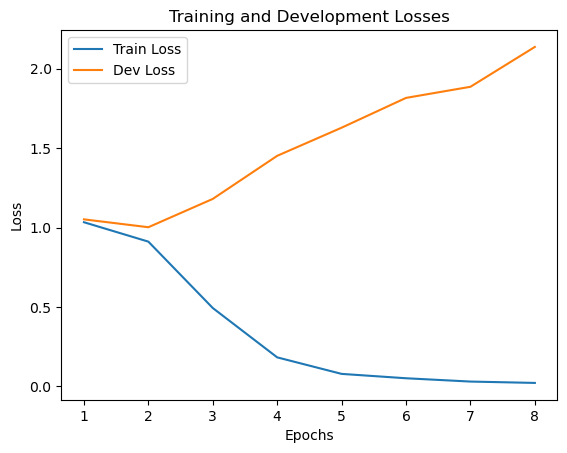

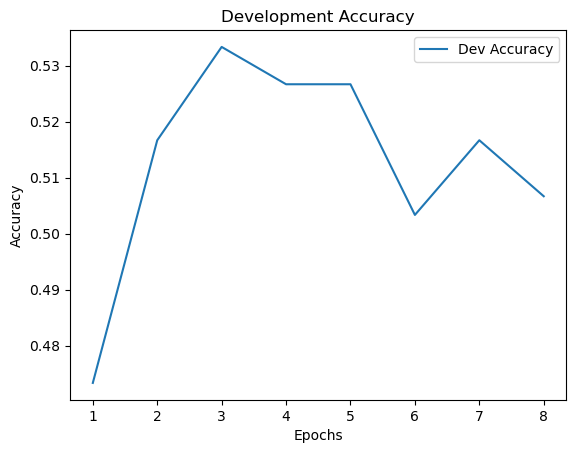

In [7]:
# Plotting the losses and accuracies
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(dev_losses) + 1), dev_losses, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Development Losses')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, len(dev_accuracies) + 1), dev_accuracies, label='Dev Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Development Accuracy')
plt.legend()
plt.show()

### RNN 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Define the RNN model for sentiment analysis
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the RNN layer (you can use LSTM/GRU as well)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden state to zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)

        # We are using the output from the last time step (out[:, -1, :])
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

# Hyperparameters
input_size_rnn = 1502 # Adjust based on input shape
hidden_size_rnn = 256
output_size_rnn = 3  # Multi-class classification (3 sentiment classes: negative, neutral, positive)
num_layers_rnn = 1
learning_rate_rnn = 0.001
num_epochs_rnn = 10

# Initialize the RNN model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn = RNN(input_size_rnn, hidden_size_rnn, output_size_rnn, num_layers_rnn).to(device)
criterion_rnn = nn.CrossEntropyLoss()  # For multi-class classification
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=learning_rate_rnn)



In [9]:
# Track losses and accuracies
train_losses_rnn = []
dev_losses_rnn = []
dev_accuracies_rnn = []

best_dev_accuracy_rnn = 0.0
best_model_state_rnn = copy.deepcopy(model_rnn.state_dict())

# Training Loop for RNN
for epoch in range(num_epochs_rnn):
    model_rnn.train()
    running_loss_rnn = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()

        # Forward pass through the RNN
        outputs_rnn = model_rnn(batch_X)
        
        # Compute the loss
        loss_rnn = criterion_rnn(outputs_rnn, batch_Y)

        # Backward and optimize
        optimizer_rnn.zero_grad()
        loss_rnn.backward()
        optimizer_rnn.step()

        running_loss_rnn += loss_rnn.item() * batch_X.size(0)

    epoch_loss_rnn = running_loss_rnn / len(train_loader.dataset)
    train_losses_rnn.append(epoch_loss_rnn)

    # Evaluation on the development set
    model_rnn.eval()
    dev_preds_rnn = []
    dev_labels_rnn = []
    dev_running_loss_rnn = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in dev_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device).long()

            outputs_rnn = model_rnn(batch_X)
            loss_rnn = criterion_rnn(outputs_rnn, batch_Y)
            dev_running_loss_rnn += loss_rnn.item() * batch_X.size(0)

            # Get the class predictions
            preds_rnn = torch.argmax(outputs_rnn, dim=1)
            dev_preds_rnn.extend(preds_rnn.cpu().numpy())
            dev_labels_rnn.extend(batch_Y.cpu().numpy())

    dev_loss_rnn = dev_running_loss_rnn / len(dev_loader.dataset)
    dev_losses_rnn.append(dev_loss_rnn)
    dev_accuracy_rnn = accuracy_score(dev_labels_rnn, dev_preds_rnn)
    dev_accuracies_rnn.append(dev_accuracy_rnn)

    print(f"Epoch [{epoch+1}/{num_epochs_rnn}], Train Loss: {epoch_loss_rnn:.4f}, Dev Loss: {dev_loss_rnn:.4f}, Dev Accuracy: {dev_accuracy_rnn:.4f}")

    # Save the best model based on dev accuracy
    if dev_accuracy_rnn > best_dev_accuracy_rnn:
        best_dev_accuracy_rnn = dev_accuracy_rnn
        best_model_state_rnn = copy.deepcopy(model_rnn.state_dict())


Epoch [1/10], Train Loss: 1.0292, Dev Loss: 1.0423, Dev Accuracy: 0.4567
Epoch [2/10], Train Loss: 0.9606, Dev Loss: 1.0215, Dev Accuracy: 0.4700
Epoch [3/10], Train Loss: 0.7509, Dev Loss: 1.1242, Dev Accuracy: 0.4067
Epoch [4/10], Train Loss: 0.4210, Dev Loss: 1.2089, Dev Accuracy: 0.4833
Epoch [5/10], Train Loss: 0.2505, Dev Loss: 1.4751, Dev Accuracy: 0.4900
Epoch [6/10], Train Loss: 0.1420, Dev Loss: 1.4652, Dev Accuracy: 0.4900
Epoch [7/10], Train Loss: 0.0942, Dev Loss: 1.8303, Dev Accuracy: 0.4700
Epoch [8/10], Train Loss: 0.1024, Dev Loss: 1.4544, Dev Accuracy: 0.5033
Epoch [9/10], Train Loss: 0.0679, Dev Loss: 1.8352, Dev Accuracy: 0.4633
Epoch [10/10], Train Loss: 0.0511, Dev Loss: 2.3458, Dev Accuracy: 0.4533


In [10]:

# Load the best model
model_rnn.load_state_dict(best_model_state_rnn)
model_rnn.eval()

# Testing on the test set
test_preds_rnn = []
test_labels_rnn = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device).long()
        outputs_rnn = model_rnn(batch_X)
        preds_rnn = torch.argmax(outputs_rnn, dim=1)
        test_preds_rnn.extend(preds_rnn.cpu().numpy())
        test_labels_rnn.extend(batch_Y.cpu().numpy())

# Calculate metrics
accuracy_rnn = accuracy_score(test_labels_rnn, test_preds_rnn)
precision_rnn, recall_rnn, f1_rnn, _ = precision_recall_fscore_support(test_labels_rnn, test_preds_rnn, average='macro')

print(f"Test Accuracy: {accuracy_rnn:.4f}")
print(f"Test Precision: {precision_rnn:.4f}")
print(f"Test Recall: {recall_rnn:.4f}")
print(f"Test F1-Score: {f1_rnn:.4f}")

# Detailed metrics for each class
precision_per_class_rnn, recall_per_class_rnn, f1_per_class_rnn, _ = precision_recall_fscore_support(
    test_labels_rnn, test_preds_rnn, labels=[0, 1, 2]
)

print("\nPer Class Metrics:")
for i in range(3):
    print(f"Class {i} - Precision: {precision_per_class_rnn[i]:.4f}, Recall: {recall_per_class_rnn[i]:.4f}, F1-Score: {f1_per_class_rnn[i]:.4f}")



Test Accuracy: 0.4740
Test Precision: 0.4218
Test Recall: 0.4201
Test F1-Score: 0.4171

Per Class Metrics:
Class 0 - Precision: 0.2229, Recall: 0.2414, F1-Score: 0.2318
Class 1 - Precision: 0.5191, Recall: 0.6126, F1-Score: 0.5620
Class 2 - Precision: 0.5235, Recall: 0.4063, F1-Score: 0.4575


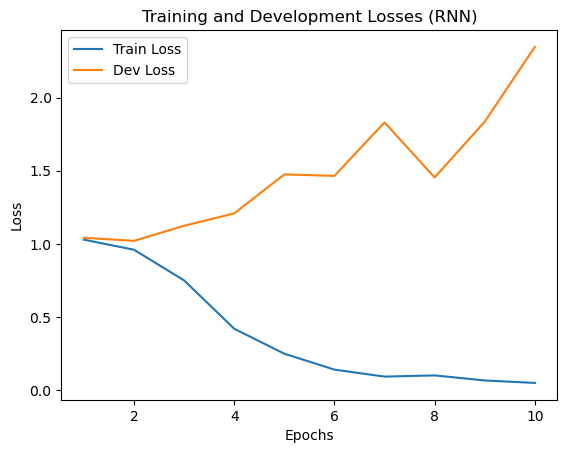

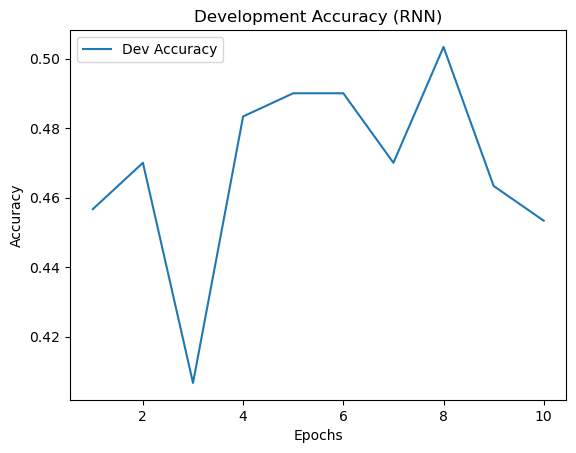

In [11]:
# Plotting the losses and accuracies
plt.figure()
plt.plot(range(1, num_epochs_rnn + 1), train_losses_rnn, label='Train Loss')
plt.plot(range(1, num_epochs_rnn + 1), dev_losses_rnn, label='Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Development Losses (RNN)')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs_rnn + 1), dev_accuracies_rnn, label='Dev Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Development Accuracy (RNN)')
plt.legend()
plt.show()
